In [7]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import pathlib
import os
import gc
import sys
import seaborn as sns
from dotenv import find_dotenv, load_dotenv

# Insert project folder into Python System
load_dotenv(find_dotenv())
sys.path.append(os.getenv("PROJECT_FOLDER"))
from src.utils import get_data_frame

In [8]:
""" LOAD DATA """
df = pd.DataFrame({})
for path in pathlib.Path("../data/raw/").glob("*.gz"):
    print(f"processing {path} ...")
    temp = get_data_frame(path)  # load .gz type data
    temp['filename'] = path.name  # add filename
    df = pd.concat([df, temp])

""" SAMPLE DATA """
df = df.groupby("overall").sample(10000, replace=True, random_state=42)
df.to_csv("../data/interim/sampled-raw-data.csv", index=False)

del df
gc.collect()

processing ..\data\raw\All_Beauty_5.json.gz ...
processing ..\data\raw\AMAZON_FASHION_5.json.gz ...
processing ..\data\raw\Appliances_5.json.gz ...
processing ..\data\raw\Digital_Music_5.json.gz ...
processing ..\data\raw\Gift_Cards_5.json.gz ...
processing ..\data\raw\Industrial_and_Scientific_5.json.gz ...
processing ..\data\raw\Luxury_Beauty_5.json.gz ...
processing ..\data\raw\Magazine_Subscriptions_5.json.gz ...
processing ..\data\raw\Prime_Pantry_5.json.gz ...
processing ..\data\raw\Software_5.json.gz ...


0

In [24]:
""" CLEAN DATA """
df = pd.read_csv("../data/interim/sampled-raw-data.csv")
df = df[["reviewTime", "filename", "reviewText", "overall"]]  # filter data
df = df.drop_duplicates()  # drop duplicates
df = df.dropna(subset=['reviewText'], axis=0)  # drop missing `reviewText` columns
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format="%m %d, %Y")  # reformat the date
df = df.reset_index(drop=True)  # reset index

In [25]:
""" DATA PREPROCESSING """
df["category"] = df['filename'].apply(lambda x: x.split('.')[0])  # get file name and use it as product category
df['sentiment'] = df['overall'].apply(lambda x: "positive" if x >= 3 else "negative")  # convert overall to sentiment
df = df.sort_values("reviewTime").reset_index(drop=True)

<Axes: xlabel='sentiment', ylabel='count'>

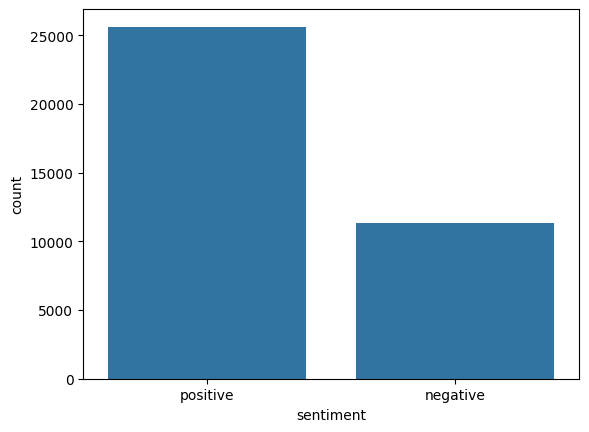

In [26]:
""" EXPLORATORY DATA ANALYSIS """
sns.countplot(x='sentiment', data=df)

In [27]:
""" Text Preprocessing """
import string
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
preprocessed_texts = []
stopwords_en = stopwords.words('english')
punctuations = string.punctuation

def preprocess_text(text: str) -> str:
    tokens = word_tokenize(text.lower())  # normalize, remove punctuations, and tokenize text
    filtered_tokens = [token for token in tokens if token not in stopwords_en and token not in punctuations]  # filter stop words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]  # lemmatize words
    return ' '.join(lemmatized_tokens)  # Join the tokens back into a string

df['preprocessed_review_text'] = df['reviewText'].apply(preprocess_text)
df = df.dropna(subset=['preprocessed_review_text'], axis=0)
df['id'] = df.index.to_list()
df = df.drop(columns=['filename', 'overall', 'reviewText'])
df = df.rename(columns={"reviewTime": "date"})
df.to_csv("../data/processed/sample-clean-data.csv", index=False)